In [87]:
import pandas as pd
# pd.set_option("display.max_rows", None, "display.max_columns", None)
import os
# pd.set_option('display.max_colwidth', -1)    # stop the column text truncating... 
# pd.set_option("display.max_rows", None, "display.max_columns", None)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pyproj import Geod


# to successfully install geopandas first run ---> pip install pyproj==2.2.0
import geopandas as gp

from shapely.geometry import Point

from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter


### CCG Geograhpical Boundaries 

The aim of this notebook is to answer the following questions 

* (Important - answer first) Does the team have the correct CCGs in the inner and outer region?
    * can we check this be inferring a distance from heathrow and checking the ccg boundaries are inside/outside?

* (Later question) Is there a way to have a map with heathrow, CCGs, GPS and the air monitoring stations? 


todo remaining:
* important... --> get lat/longitutes from other airports in LONDON... (and luton?)
* (extended) search for GP lat,long points (what can you use to get lat long points etc) 


DONE 
> * map the airport points on the graph (heathrow etc), copy https://towardsdatascience.com/geopandas-101-plot-any-data-with-a-latitude-and-longitude-on-a-map-98e01944b972
> * use pandas... to calculate the different distances from heathrow airport
> * you can then limit ccgs based on the distance from midpoint (given in shape descriptiomn)


Findings:
* discuss East Berkshire

In [88]:
# Data Source
# https://geoportal.statistics.gov.uk/search?q=clinical%20comissioning%20groups

# MOST USEFUL ONE Mapping with the SHAPE FILES...
# https://towardsdatascience.com/geopandas-101-plot-any-data-with-a-latitude-and-longitude-on-a-map-98e01944b972




# others
# https://towardsdatascience.com/lets-make-a-map-using-geopandas-pandas-and-matplotlib-to-make-a-chloropleth-map-dddc31c1983d
    # accompanying link containing borough files https://data.london.gov.uk/dataset/statistical-gis-boundary-files-london

# overlay midpoint

# this method is quite complicated (try geopandas first as it had a lower barrier of entry & is similar to pandas)
# https://towardsdatascience.com/mapping-geograph-data-in-python-610a963d2d7f

        # after... we will need to learn how to put points on the shape file... as a next step 

# https://geoportal.statistics.gov.uk/datasets/clinical-commissioning-groups-april-2019-names-and-codes-in-england
# VECTOR BOUNDARIES AND SHAPE FILES...

# https://towardsdatascience.com/a-complete-guide-to-an-interactive-geographical-map-using-python-f4c5197e23e0
# * geopandas...


# plotting basemap (also showed how to change the crs mode (required for coordinate here)) https://geopandas.org/gallery/plotting_basemap_background.html

In [89]:
# remember to keep the geometry field truncated... (otherwise this ruins head)
shp_filepath = 'Clinical_Commissioning_Groups__April_2019__Boundaries_EN_BFC-shp/Clinical_Commissioning_Groups__April_2019__Boundaries_EN_BFC.shp'

ldn_map_df = gp.read_file(shp_filepath)

# # check data type so we can see that this is not a normal dataframe, but a GEOdataframe
ldn_map_df.head(10)

# convert the df to lat,long format (required)
ldn_map_df = ldn_map_df.to_crs(epsg=4326)

# altetnaticve way to convert format (see below)
crs = {'init': 'epsg:4326'}

In [90]:
# create airport df so we can visualise them on the map

data = {'LOC_NAME':['Heathrow Airport'],
        'LONG':[-0.454295],
        'LAT': [51.470020],
        'geometry': ['empty'],  
       }
df = pd.DataFrame(data)

# create geometry column
geometry = [Point(xy) for xy in zip(df['LONG'], df['LAT'])]
df.geometry = geometry

# convert the airports df into a geo_df (so that it plots...)
geo_df_airport = gp.GeoDataFrame(df, crs=crs)

geo_df_airport.head()

,LOC_NAME,LONG,LAT,geometry
0,Heathrow Airport,-0.454295,51.47002,POINT (-0.454295 51.47002)


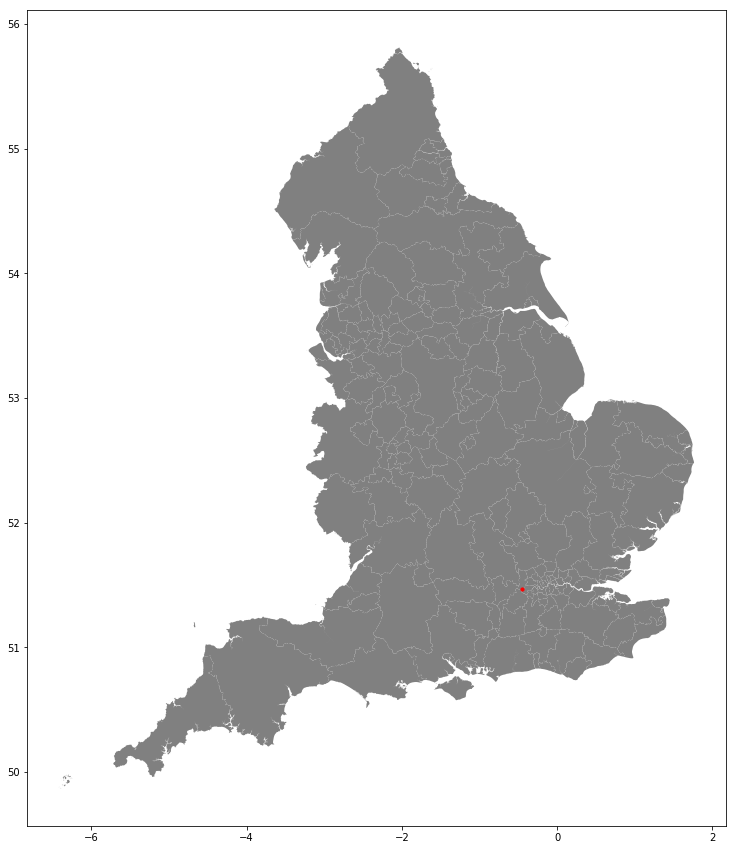

In [91]:
# plot the heathrow airport as a overlay on our ccg map... 

fig, ax = plt.subplots(figsize=(15,15))
ldn_map_df.plot(ax=ax, color='grey',)
geo_df_airport.plot(ax=ax, markersize=10, color='red', marker='o')


## Limit the CCGs

We will now use distancing (from the midpoint of the ccg region), to determine the CCGs to keep around heathrow 

In [92]:
# resources
# https://gis.stackexchange.com/questions/279109/calculate-distance-between-a-coordinate-and-a-county-in-geopandas

ldn_map_df.head()


,OBJECTID,CCG19CD,CCG19NM,BNG_E,BNG_N,LONG,LAT,Shape__Are,Shape__Len,geometry
0,1,E38000001,"NHS Airedale, Wharfedale and Craven CCG",393990,462191,-2.093300,54.0556,1.220633e+09,222000.154543,POLYGON ((-2.004504131263194 54.17287207348864...
1,2,E38000002,NHS Ashford CCG,597640,140644,0.823374,51.1310,5.806172e+08,149426.082727,"POLYGON ((1.003939402203813 51.18005084706247,..."
2,3,E38000004,NHS Barking and Dagenham CCG,547758,185109,0.129493,51.5455,3.609104e+07,40665.310992,(POLYGON ((0.06912579948535737 51.538811067235...
3,4,E38000005,NHS Barnet CCG,523471,191753,-0.218220,51.6111,8.673644e+07,50842.313101,POLYGON ((-0.1821100786890796 51.6686008286288...
4,5,E38000006,NHS Barnsley CCG,429979,403330,-1.549250,53.5258,3.290521e+08,125518.601736,POLYGON ((-1.348646247507583 53.58331342624416...


In [93]:
# get distance between two lat long points
# https://stackoverflow.com/questions/44446862/calculate-distance-between-latitude-and-longitude-in-dataframe

heathrow_lat, heathrow_lon = 51.47002, -0.454295

# https://pyproj4.github.io/pyproj/stable/api/geod.html
wgs84_geod = Geod(ellps='WGS84') #Distance will be measured on this ellipsoid - more accurate than a spherical method

def get_distance(lat1, lon1, lat2, lon2):
    # distance is returned in metres (cross-checked on site)
    az12,az21,dist = wgs84_geod.inv(lon1,lat1,lon2,lat2) 
    return(dist)
    
def calc_heathrow_dist(row):
    return get_distance(heathrow_lat, heathrow_lon, row['LAT'], row['LONG'])


def calc_heathrow_dist_from_latlong(lat_long):
    try:
        return get_distance(heathrow_lat, heathrow_lon, lat_long[0], lat_long[1]) 
    except TypeError:
        print(lat_long)
        return 'nothing'


In [94]:

get_distance(-0.454295, 51.47002,0.129493, 51.5455)

ldn_map_df_dist = ldn_map_df.copy()

ldn_map_df_dist['heathrow_distance'] = ldn_map_df_dist.apply(calc_heathrow_dist, axis=1)

In [95]:
ldn_map_df_dist.head()

,OBJECTID,CCG19CD,CCG19NM,BNG_E,BNG_N,LONG,LAT,Shape__Are,Shape__Len,geometry,heathrow_distance
0,1,E38000001,"NHS Airedale, Wharfedale and Craven CCG",393990,462191,-2.093300,54.0556,1.220633e+09,222000.154543,POLYGON ((-2.004504131263194 54.17287207348864...,308245.341033
1,2,E38000002,NHS Ashford CCG,597640,140644,0.823374,51.1310,5.806172e+08,149426.082727,"POLYGON ((1.003939402203813 51.18005084706247,...",96760.747562
2,3,E38000004,NHS Barking and Dagenham CCG,547758,185109,0.129493,51.5455,3.609104e+07,40665.310992,(POLYGON ((0.06912579948535737 51.538811067235...,41392.357632
3,4,E38000005,NHS Barnet CCG,523471,191753,-0.218220,51.6111,8.673644e+07,50842.313101,POLYGON ((-0.1821100786890796 51.6686008286288...,22685.542828
4,5,E38000006,NHS Barnsley CCG,429979,403330,-1.549250,53.5258,3.290521e+08,125518.601736,POLYGON ((-1.348646247507583 53.58331342624416...,240535.635808


/opt/conda/lib/python3.6/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  super(GeoDataFrame, self).__setitem__(key, value)


['NHS Brent CCG' 'NHS Ealing CCG' 'NHS Hammersmith and Fulham CCG'
 'NHS Harrow CCG' 'NHS Hillingdon CCG' 'NHS Hounslow CCG'
 'NHS Kingston CCG' 'NHS North West Surrey CCG' 'NHS Richmond CCG'
 'NHS East Berkshire CCG']


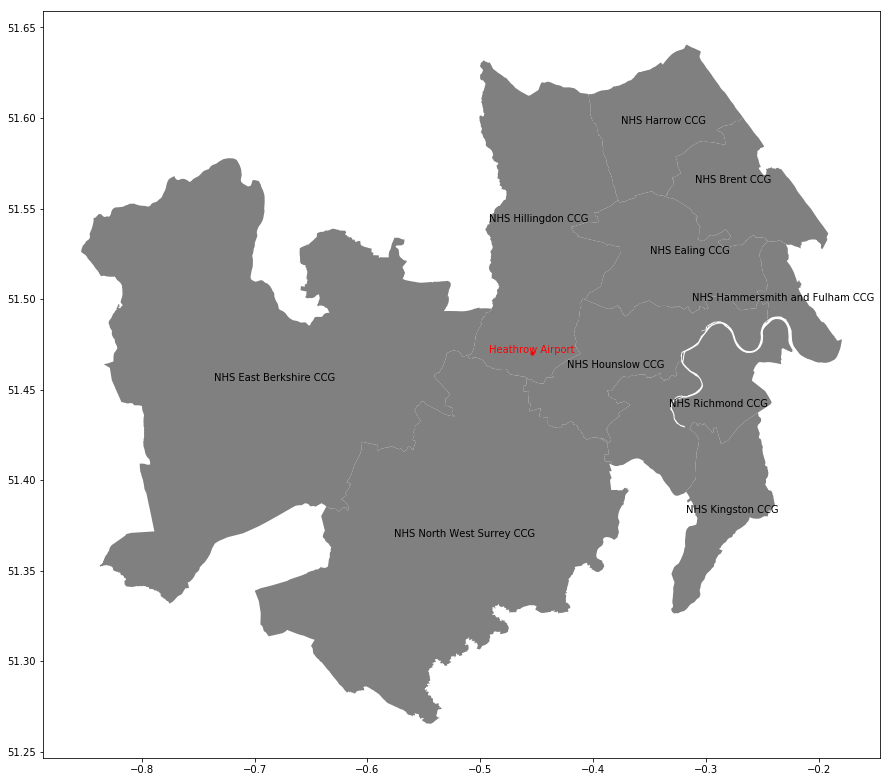

In [96]:
smaller_df = ldn_map_df_dist[ldn_map_df_dist['heathrow_distance'] <= 17500]

# solution inspired by stackoverflow. can also use (long,lat) as the midpoint
# https://stackoverflow.com/questions/38899190/geopandas-label-polygons
smaller_df['coords'] = smaller_df['geometry'].apply(lambda x: x.representative_point().coords[:])
smaller_df['coords'] = [coords[0] for coords in smaller_df['coords']]


fig, ax = plt.subplots(figsize=(15,15))
smaller_df.plot(ax=ax, color='grey',)
geo_df_airport.plot(ax=ax, markersize=10, color='red', marker='o')

# plot the names on the midpoints
for idx, row in smaller_df.iterrows():
    plt.annotate(s=row['CCG19NM'], xy=row['coords'],
                 horizontalalignment='center')
    
# do the same for the airports (complete airport_df tomorrow)    
for idx, row in geo_df_airport.iterrows():
    plt.annotate(s=row['LOC_NAME'], xy=((row['LONG'], row['LAT'])),
                 horizontalalignment='center', color='red')
    

print(smaller_df.CCG19NM.unique())


In [97]:
inner_ccgs = ['NHS Buckinghamshire CCG', 'NHS Ealing CCG', 'NHS East Berkshire CCG', 'NHS Hillingdon CCG',
 'NHS Hounslow CCG', 'NHS North West Surrey CCG']

outer_ccgs =  ['NHS Basildon And Brentwood CCG', 'NHS Berkshire West CCG', 'NHS Brent CCG', 'NHS Croydon CCG',
               'NHS Guildford and Waverley CCG', 'NHS Hammersmith And Fulham CCG', 'NHS Harrow CCG', 
               'NHS Herts Valleys CCG', 'NHS Kingston CCG', 'NHS Merton CCG', 'NHS Oxfordshire CCG', 
               'NHS Richmond CCG', 'NHS Surrey Heath CCG', 'NHS Sutton CCG', 'NHS Wandsworth CCG']

## Part 2: Plot Other Points of Interest on The Map (Airports... GPs etc.)

### Overlaying airports

In [98]:
# Inspired by https://towardsdatascience.com/geocode-with-python-161ec1e62b89

locator = Nominatim(user_agent='myGeocoder')
location = locator.geocode('Heathrow Airport, England')

In [99]:
print((location.raw))

{'place_id': 134195200, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright', 'osm_type': 'way', 'osm_id': 185882029, 'boundingbox': ['51.4560987', '51.4794056', '-0.4943776', '-0.4151697'], 'lat': '51.46773895', 'lon': '-0.4587800741571181', 'display_name': 'London Heathrow Airport, Gleneagles Close, Stanwell, Spelthorne, Surrey, South East, England, TW19 7NP, United Kingdom', 'class': 'aeroway', 'type': 'aerodrome', 'importance': 0.8661714371841469, 'icon': 'https://nominatim.openstreetmap.org/ui/mapicons//transport_airport2.p.20.png'}


In [100]:
# build a dataframe from a series of airport locations... 
# https://gis.stackexchange.com/questions/331144/bulk-reverse-geocoding-with-geopy-using-built-in-rate-limiter
airport_list_dict = []

Airports = ['London City Airport', 'London Gatwick Airport', 'London Heathrow Airport', 'London Luton Airport', 'London Stansted Airport', 'London Southend Airport']

geocode = RateLimiter(locator.geocode, min_delay_seconds=0.2)

for airport in Airports:
    address = (geocode(airport))
    airport_list_dict.append(
    {
      'NAME'  : airport,
      'ADDRESS'  : address,
      'LONG'  : address.longitude,
      'LAT'  : address.latitude,
    }
    )

airport_df = pd.DataFrame(airport_list_dict)
airport_geo = gp.GeoDataFrame(airport_df, geometry=gp.points_from_xy(airport_df['LONG'], airport_df['LAT']))
airport_geo.head()

,ADDRESS,LAT,LONG,NAME,geometry
0,"(London City Airport, Hartmann Road, Galleons ...",51.504266,0.054913,London City Airport,POINT (0.05491293705863423 51.5042655)
1,"(London Gatwick Airport, Povey Cross Road, Cra...",51.154106,-0.180388,London Gatwick Airport,POINT (-0.1803875560472005 51.1541065)
2,"(London Heathrow Airport, Gleneagles Close, St...",51.467739,-0.458780,London Heathrow Airport,POINT (-0.4587800741571181 51.46773895)
3,"(London Luton Airport, Percival Way, Wigmore, ...",51.878140,-0.366457,London Luton Airport,POINT (-0.3664573292436831 51.87814035)
4,"(London Stansted Airport, Terminal Road South,...",51.886965,0.244193,London Stansted Airport,POINT (0.244192901573303 51.88696515)


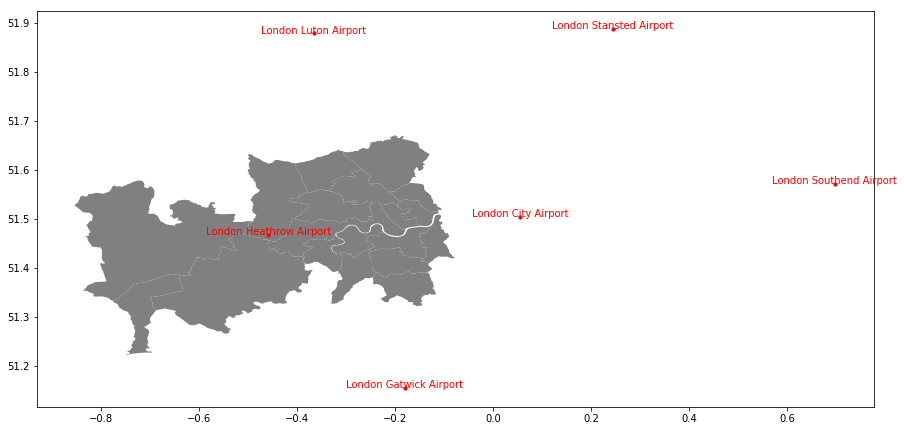

In [101]:
ccg_df = ldn_map_df_dist[ldn_map_df_dist['heathrow_distance'] <= 25000]


fig, ax = plt.subplots(figsize=(15,15))
ccg_df.plot(ax=ax, color='grey')
airport_geo.plot(ax=ax, markersize=10, color='red', marker='o')


# plot names for the boroughs
# for idx, row in ccg_df.iterrows():
#     plt.annotate(s=row['CCG19NM'], xy=((row['LONG'], row['LAT'])),
#                  horizontalalignment='center')
    

# plot names for the airports (complete airport_df tomorrow)    
for idx, row in airport_geo.iterrows():
    plt.annotate(s=row['NAME'], xy=((row['LONG'], row['LAT'])),
                 horizontalalignment='center', color='red')

### Overlaying GPs

In [102]:
# pull in GP data:

qof_full_gp = pd.read_csv('../fingertips/data_output/nhs_qof_dataset/nhs_qof_dataset.csv')


#restrict to GP
qof_full_gp = qof_full_gp[qof_full_gp['Area Type'] == 'GP']

qof_full_gp.head()

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (10,11,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,Indicator ID,Indicator Name,Parent Code,Parent Name,Area Code,Area Name,Area Type,Sex,Age,...,Upper CI 99.8 limit,Count,Denominator,Value note,Recent Trend,Compared to England value or percentiles,Compared to percentiles,Time period Sortable,New data,Compared to goal
26390,26390,219,Hypertension: QOF prevalence (all ages),E92000001,England,A81001,The Densham Surgery,GP,Persons,All ages,...,NaN,579.0,4164.0,NaN,NaN,Similar,Not compared,20090000,NaN,NaN
26391,26391,219,Hypertension: QOF prevalence (all ages),E92000001,England,A81002,Queens Park Medical Centre,GP,Persons,All ages,...,NaN,3225.0,20588.0,NaN,NaN,Higher,Not compared,20090000,NaN,NaN
26392,26392,219,Hypertension: QOF prevalence (all ages),E92000001,England,A81004,Bluebell Medical Centre,GP,Persons,All ages,...,NaN,1230.0,8271.0,NaN,NaN,Higher,Not compared,20090000,NaN,NaN
26393,26393,219,Hypertension: QOF prevalence (all ages),E92000001,England,A81005,Springwood Surgery,GP,Persons,All ages,...,NaN,1376.0,7972.0,NaN,NaN,Higher,Not compared,20090000,NaN,NaN
26394,26394,219,Hypertension: QOF prevalence (all ages),E92000001,England,A81006,Tennant Street Medical Practice,GP,Persons,All ages,...,NaN,1863.0,12365.0,NaN,NaN,Higher,Not compared,20090000,NaN,NaN


In [103]:
# alternative - google maps --> this could be charged... 
# https://stackoverflow.com/questions/6159074/given-the-lat-long-coordinates-how-can-we-find-out-the-city-country
import geopandas as gp

qof_gps = qof_full_gp['Area Name'].unique()
print(len(qof_gps))
qof_gp_lst_dict = []

counter= 0

for gp_name in qof_gps[0:50]:
    counter += 1
    print('sourcing address for GP {0} out of {1}'.format(counter, len(qof_gps[0:50])))
    print('the GP name is: {0}'.format(gp_name))
    print('\n')
    try:
        address = (geocode(gp_name + ', England'))
        qof_gp_lst_dict.append(
            {
              'NAME'  : gp_name,
              'ADDRESS'  : address,
              'LONG'  : address.longitude,
              'LAT'  : address.latitude,
            }
        )
    except AttributeError:
        qof_gp_lst_dict.append(
            {
              'NAME'  : gp_name,
              'ADDRESS'  : 'Not Found',
              'LONG'  : None,
              'LAT'  : None,
            }
        )
        
gp_df = pd.DataFrame(qof_gp_lst_dict)
gp_geo = gp.GeoDataFrame(gp_df, geometry=gp.points_from_xy(gp_df['LONG'], gp_df['LAT']))
gp_geo.head()


6346
sourcing address for GP 1 out of 50
the GP name is: The Densham Surgery


sourcing address for GP 2 out of 50
the GP name is: Queens Park Medical Centre


sourcing address for GP 3 out of 50
the GP name is: Bluebell Medical Centre


sourcing address for GP 4 out of 50
the GP name is: Springwood Surgery


sourcing address for GP 5 out of 50
the GP name is: Tennant Street Medical Practice


sourcing address for GP 6 out of 50
the GP name is: Bankhouse Surgery


sourcing address for GP 7 out of 50
the GP name is: Village Medical Centre


sourcing address for GP 8 out of 50
the GP name is: Chadwick Practice


sourcing address for GP 9 out of 50
the GP name is: Westbourne Medical Centre


sourcing address for GP 10 out of 50
the GP name is: Brotton Surgery


sourcing address for GP 11 out of 50
the GP name is: Queenstree Practice


sourcing address for GP 12 out of 50
the GP name is: Park Surgery


sourcing address for GP 13 out of 50
the GP name is: Woodbridge Practice


sourcing addr

,ADDRESS,LAT,LONG,NAME,geometry
0,"(Lawson Street Medical Centre Densham Surgery,...",54.561447,-1.318668,The Densham Surgery,POINT (-1.3186682 54.5614466)
1,"(Queens Park Medical Centre, Carlisle Road, Qu...",52.133176,-0.492302,Queens Park Medical Centre,POINT (-0.492302176309013 52.1331755)
2,"(Bluebell Medical Centre, Bluebell Road, Winco...",53.417424,-1.435596,Bluebell Medical Centre,POINT (-1.4355965 53.4174244)
3,"(The Springwood Surgery, Spring Wood Road, Gui...",54.532818,-1.053622,Springwood Surgery,POINT (-1.0536224 54.5328175)
4,Not Found,NaN,NaN,Tennant Street Medical Practice,POINT (nan nan)


In [104]:
def get_long_lat(row):
    print('sourcing address for {0}'.format(row['NAME']))
    try:
        address = (geocode(row['ADDRESS']))
        return (address.longitude, address.latitude)

    except AttributeError:
        
        try:
            address = (geocode(row['POSTCODE']))
            return (address.longitude, address.latitude)
        
        except AttributeError:
            return None


In [105]:
nhs_gp2= pd.read_csv('epraccur.csv', encoding='utf-8')

nhs_gp2 = nhs_gp2.fillna('')
nhs_gp2['ADDRESS'] = nhs_gp2['ADDRESS_1'] + ', ' + nhs_gp2['ADDRESS_2'] + ', ' + nhs_gp2['ADDRESS_3'] + ', ' + nhs_gp2['POSTCODE'] 

In [106]:
nhs_gp2.head()

,ORG_CODE,NAME,NATIONAL_GROUPING,HEALTH_GEOG,ADDRESS_1,ADDRESS_2,ADDRESS_3,ADDRESS_4,ADDRESS_5,POSTCODE,...,STATUS_CODE,ORG_SUB_CODE,COMMISIONER_CODE,JOIN_PROVIDER_DATE,LEFT_PROVIDER_DATE,TELE,RECORD_AMENDED,PROVIDER_PURCHASER,PRESCRIBING_SETTING,ADDRESS
0,A81001,THE DENSHAM SURGERY,Y63,QHM,THE HEALTH CENTRE,LAWSON STREET,STOCKTON-ON-TEES,CLEVELAND,,TS18 1HU,...,A,B,16C,2.02004e+07,,01642 672351,0,16C,4,"THE HEALTH CENTRE, LAWSON STREET, STOCKTON-ON-..."
1,A81002,QUEENS PARK MEDICAL CENTRE,Y63,QHM,QUEENS PARK MEDICAL CTR,FARRER STREET,STOCKTON ON TEES,CLEVELAND,,TS18 2AW,...,A,B,16C,2.02004e+07,,01642 679681,0,16C,4,"QUEENS PARK MEDICAL CTR, FARRER STREET, STOCKT..."
2,A81003,VICTORIA MEDICAL PRACTICE,Y54,Q74,THE HEALTH CENTRE,VICTORIA ROAD,HARTLEPOOL,CLEVELAND,,TS26 8DB,...,C,B,00K,2.01304e+07,2.0171e+07,01429 272945,0,00K,4,"THE HEALTH CENTRE, VICTORIA ROAD, HARTLEPOOL, ..."
3,A81004,BLUEBELL MEDICAL CENTRE,Y63,QHM,TRIMDON AVENUE,ACKLAM,MIDDLESBROUGH,,,TS5 8SB,...,A,B,16C,2.02004e+07,,01642 827697,0,16C,4,"TRIMDON AVENUE, ACKLAM, MIDDLESBROUGH, TS5 8SB"
4,A81005,SPRINGWOOD SURGERY,Y63,QHM,SPRINGWOOD SURGERY,RECTORY LANE,GUISBOROUGH,,,TS14 7DJ,...,A,B,16C,2.02004e+07,,01287 619611,0,16C,4,"SPRINGWOOD SURGERY, RECTORY LANE, GUISBOROUGH,..."


In [107]:
# nhs_gp2['LOCATION'] = nhs_gp2.head(30)['ADDRESS'].apply(geocode)

# nhs_gp2['LOCATION'] = nhs_gp2.apply(get_long_lat, axis=1)


In [108]:
# nhs_gp2.to_csv('nhs_gp_latlong_20210111.CSV', encoding='utf-8')


In [109]:
nhs_gp2.head()

,ORG_CODE,NAME,NATIONAL_GROUPING,HEALTH_GEOG,ADDRESS_1,ADDRESS_2,ADDRESS_3,ADDRESS_4,ADDRESS_5,POSTCODE,...,STATUS_CODE,ORG_SUB_CODE,COMMISIONER_CODE,JOIN_PROVIDER_DATE,LEFT_PROVIDER_DATE,TELE,RECORD_AMENDED,PROVIDER_PURCHASER,PRESCRIBING_SETTING,ADDRESS
0,A81001,THE DENSHAM SURGERY,Y63,QHM,THE HEALTH CENTRE,LAWSON STREET,STOCKTON-ON-TEES,CLEVELAND,,TS18 1HU,...,A,B,16C,2.02004e+07,,01642 672351,0,16C,4,"THE HEALTH CENTRE, LAWSON STREET, STOCKTON-ON-..."
1,A81002,QUEENS PARK MEDICAL CENTRE,Y63,QHM,QUEENS PARK MEDICAL CTR,FARRER STREET,STOCKTON ON TEES,CLEVELAND,,TS18 2AW,...,A,B,16C,2.02004e+07,,01642 679681,0,16C,4,"QUEENS PARK MEDICAL CTR, FARRER STREET, STOCKT..."
2,A81003,VICTORIA MEDICAL PRACTICE,Y54,Q74,THE HEALTH CENTRE,VICTORIA ROAD,HARTLEPOOL,CLEVELAND,,TS26 8DB,...,C,B,00K,2.01304e+07,2.0171e+07,01429 272945,0,00K,4,"THE HEALTH CENTRE, VICTORIA ROAD, HARTLEPOOL, ..."
3,A81004,BLUEBELL MEDICAL CENTRE,Y63,QHM,TRIMDON AVENUE,ACKLAM,MIDDLESBROUGH,,,TS5 8SB,...,A,B,16C,2.02004e+07,,01642 827697,0,16C,4,"TRIMDON AVENUE, ACKLAM, MIDDLESBROUGH, TS5 8SB"
4,A81005,SPRINGWOOD SURGERY,Y63,QHM,SPRINGWOOD SURGERY,RECTORY LANE,GUISBOROUGH,,,TS14 7DJ,...,A,B,16C,2.02004e+07,,01287 619611,0,16C,4,"SPRINGWOOD SURGERY, RECTORY LANE, GUISBOROUGH,..."


In [130]:
def calc_heathrow_dist_from_latlong(lat_long):
    return get_distance(heathrow_lat, heathrow_lon, lat_long[0], lat_long[1]) 

In [127]:
nhs_gp2 = pd.read_csv('nhs_gp_latlong_20210111.CSV', encoding='utf-8')

In [134]:
nhs_gp2.head()

,Unnamed: 0,ORG_CODE,NAME,NATIONAL_GROUPING,HEALTH_GEOG,ADDRESS_1,ADDRESS_2,ADDRESS_3,ADDRESS_4,ADDRESS_5,...,ORG_SUB_CODE,COMMISIONER_CODE,JOIN_PROVIDER_DATE,LEFT_PROVIDER_DATE,TELE,RECORD_AMENDED,PROVIDER_PURCHASER,PRESCRIBING_SETTING,ADDRESS,LOCATION
0,0,A81001,THE DENSHAM SURGERY,Y63,QHM,THE HEALTH CENTRE,LAWSON STREET,STOCKTON-ON-TEES,CLEVELAND,NaN,...,B,16C,20200401.0,NaN,01642 672351,0,16C,4,"THE HEALTH CENTRE, LAWSON STREET, STOCKTON-ON-...","(-1.3184148, 54.5611002)"
1,1,A81002,QUEENS PARK MEDICAL CENTRE,Y63,QHM,QUEENS PARK MEDICAL CTR,FARRER STREET,STOCKTON ON TEES,CLEVELAND,NaN,...,B,16C,20200401.0,NaN,01642 679681,0,16C,4,"QUEENS PARK MEDICAL CTR, FARRER STREET, STOCKT...","(-1.313866888882218, 54.56917125)"
2,2,A81003,VICTORIA MEDICAL PRACTICE,Y54,Q74,THE HEALTH CENTRE,VICTORIA ROAD,HARTLEPOOL,CLEVELAND,NaN,...,B,00K,20130401.0,20171031.0,01429 272945,0,00K,4,"THE HEALTH CENTRE, VICTORIA ROAD, HARTLEPOOL, ...","(-1.2195137, 54.6854736)"
3,3,A81004,BLUEBELL MEDICAL CENTRE,Y63,QHM,TRIMDON AVENUE,ACKLAM,MIDDLESBROUGH,NaN,NaN,...,B,16C,20200401.0,NaN,01642 827697,0,16C,4,"TRIMDON AVENUE, ACKLAM, MIDDLESBROUGH, TS5 8SB","(-1.2622495, 54.5399797)"
4,4,A81005,SPRINGWOOD SURGERY,Y63,QHM,SPRINGWOOD SURGERY,RECTORY LANE,GUISBOROUGH,NaN,NaN,...,B,16C,20200401.0,NaN,01287 619611,0,16C,4,"SPRINGWOOD SURGERY, RECTORY LANE, GUISBOROUGH,...","(-1.0531021, 54.5329389)"


In [140]:
# nhs_gp2[['lat', 'long']] = pd.DataFrame(nhs_gp2['LOCATION'].tolist(), index=nhs_gp2.index) 

nhs_3 = pd.concat([nhs_gp2, nhs_gp2['LOCATION'].str[1:-1].str.split(',', expand=True).astype(float)], axis=1).rename(columns={0:'LONG', 1:'LAT'})
nhs_3

,Unnamed: 0,ORG_CODE,NAME,NATIONAL_GROUPING,HEALTH_GEOG,ADDRESS_1,ADDRESS_2,ADDRESS_3,ADDRESS_4,ADDRESS_5,...,JOIN_PROVIDER_DATE,LEFT_PROVIDER_DATE,TELE,RECORD_AMENDED,PROVIDER_PURCHASER,PRESCRIBING_SETTING,ADDRESS,LOCATION,LONG,LAT
0,0,A81001,THE DENSHAM SURGERY,Y63,QHM,THE HEALTH CENTRE,LAWSON STREET,STOCKTON-ON-TEES,CLEVELAND,NaN,...,20200401.0,NaN,01642 672351,0,16C,4,"THE HEALTH CENTRE, LAWSON STREET, STOCKTON-ON-...","(-1.3184148, 54.5611002)",-1.318415,54.561100
1,1,A81002,QUEENS PARK MEDICAL CENTRE,Y63,QHM,QUEENS PARK MEDICAL CTR,FARRER STREET,STOCKTON ON TEES,CLEVELAND,NaN,...,20200401.0,NaN,01642 679681,0,16C,4,"QUEENS PARK MEDICAL CTR, FARRER STREET, STOCKT...","(-1.313866888882218, 54.56917125)",-1.313867,54.569171
2,2,A81003,VICTORIA MEDICAL PRACTICE,Y54,Q74,THE HEALTH CENTRE,VICTORIA ROAD,HARTLEPOOL,CLEVELAND,NaN,...,20130401.0,20171031.0,01429 272945,0,00K,4,"THE HEALTH CENTRE, VICTORIA ROAD, HARTLEPOOL, ...","(-1.2195137, 54.6854736)",-1.219514,54.685474
3,3,A81004,BLUEBELL MEDICAL CENTRE,Y63,QHM,TRIMDON AVENUE,ACKLAM,MIDDLESBROUGH,NaN,NaN,...,20200401.0,NaN,01642 827697,0,16C,4,"TRIMDON AVENUE, ACKLAM, MIDDLESBROUGH, TS5 8SB","(-1.2622495, 54.5399797)",-1.262250,54.539980
4,4,A81005,SPRINGWOOD SURGERY,Y63,QHM,SPRINGWOOD SURGERY,RECTORY LANE,GUISBOROUGH,NaN,NaN,...,20200401.0,NaN,01287 619611,0,16C,4,"SPRINGWOOD SURGERY, RECTORY LANE, GUISBOROUGH,...","(-1.0531021, 54.5329389)",-1.053102,54.532939
5,5,A81006,TENNANT STREET MEDICAL PRACTICE,Y63,QHM,TENNANT ST MEDICAL PRACT,TENNANT STREET,STOCKTON-ON-TEES,CLEVELAND,NaN,...,20200401.0,NaN,01642 613331,0,16C,4,"TENNANT ST MEDICAL PRACT, TENNANT STREET, STOC...","(-1.313579691315803, 54.56860407748905)",-1.313580,54.568604
6,6,A81007,BANKHOUSE SURGERY,Y63,QHM,ONE LIFE HARTLEPOOL,PARK ROAD,HARTLEPOOL,CLEVELAND,NaN,...,20200401.0,NaN,01429 274800,0,16C,4,"ONE LIFE HARTLEPOOL, PARK ROAD, HARTLEPOOL, TS...","(-1.2151997497763005, 54.6818935)",-1.215200,54.681894
7,7,A81008,ALBERT HOUSE CLINIC,Y54,Q74,LOW GRANGE HEALTH VILLAGE,NORMANBY ROAD,MIDDLESBROUGH,CLEVELAND,NaN,...,20130401.0,20180131.0,01642 466776,0,00M,4,"LOW GRANGE HEALTH VILLAGE, NORMANBY ROAD, MIDD...","(-1.1603574, 54.5727458)",-1.160357,54.572746
8,8,A81009,VILLAGE MEDICAL CENTRE,Y63,QHM,THE VILLAGE MEDICAL CTR,400/404 LINTHORPE ROAD,MIDDLESBROUGH,CLEVELAND,NaN,...,20200401.0,NaN,01642 851122,0,16C,4,"THE VILLAGE MEDICAL CTR, 400/404 LINTHORPE ROA...","(-1.2418832890578835, 54.56227181733046)",-1.241883,54.562272
9,9,A81011,CHADWICK PRACTICE,Y63,QHM,ONE LIFE HARTLEPOOL,PARK ROAD,HARTLEPOOL,CLEVELAND,NaN,...,20200401.0,NaN,01429 234646,0,16C,4,"ONE LIFE HARTLEPOOL, PARK ROAD, HARTLEPOOL, TS...","(-1.2151997497763005, 54.6818935)",-1.215200,54.681894


In [142]:
# nhs_gp2['heathrow_distance'] = nhs_gp2['LOCATION'].apply(calc_heathrow_dist_from_latlong)
nhs_3['heathrow_distance'] = nhs_3.apply(calc_heathrow_dist, axis=1)

In [147]:
gp_geo = gp.GeoDataFrame(nhs_3, geometry=gp.points_from_xy(nhs_3['LONG'], nhs_3['LAT']))
gp_geo.head()

,Unnamed: 0,ORG_CODE,NAME,NATIONAL_GROUPING,HEALTH_GEOG,ADDRESS_1,ADDRESS_2,ADDRESS_3,ADDRESS_4,ADDRESS_5,...,TELE,RECORD_AMENDED,PROVIDER_PURCHASER,PRESCRIBING_SETTING,ADDRESS,LOCATION,LONG,LAT,heathrow_distance,geometry
0,0,A81001,THE DENSHAM SURGERY,Y63,QHM,THE HEALTH CENTRE,LAWSON STREET,STOCKTON-ON-TEES,CLEVELAND,NaN,...,01642 672351,0,16C,4,"THE HEALTH CENTRE, LAWSON STREET, STOCKTON-ON-...","(-1.3184148, 54.5611002)",-1.318415,54.561100,348842.333865,POINT (-1.3184148 54.5611002)
1,1,A81002,QUEENS PARK MEDICAL CENTRE,Y63,QHM,QUEENS PARK MEDICAL CTR,FARRER STREET,STOCKTON ON TEES,CLEVELAND,NaN,...,01642 679681,0,16C,4,"QUEENS PARK MEDICAL CTR, FARRER STREET, STOCKT...","(-1.313866888882218, 54.56917125)",-1.313867,54.569171,349676.983415,POINT (-1.313866888882218 54.56917125)
2,2,A81003,VICTORIA MEDICAL PRACTICE,Y54,Q74,THE HEALTH CENTRE,VICTORIA ROAD,HARTLEPOOL,CLEVELAND,NaN,...,01429 272945,0,00K,4,"THE HEALTH CENTRE, VICTORIA ROAD, HARTLEPOOL, ...","(-1.2195137, 54.6854736)",-1.219514,54.685474,361490.188752,POINT (-1.2195137 54.6854736)
3,3,A81004,BLUEBELL MEDICAL CENTRE,Y63,QHM,TRIMDON AVENUE,ACKLAM,MIDDLESBROUGH,NaN,NaN,...,01642 827697,0,16C,4,"TRIMDON AVENUE, ACKLAM, MIDDLESBROUGH, TS5 8SB","(-1.2622495, 54.5399797)",-1.262250,54.539980,345916.416929,POINT (-1.2622495 54.5399797)
4,4,A81005,SPRINGWOOD SURGERY,Y63,QHM,SPRINGWOOD SURGERY,RECTORY LANE,GUISBOROUGH,NaN,NaN,...,01287 619611,0,16C,4,"SPRINGWOOD SURGERY, RECTORY LANE, GUISBOROUGH,...","(-1.0531021, 54.5329389)",-1.053102,54.532939,343219.586336,POINT (-1.0531021 54.5329389)


/opt/conda/lib/python3.6/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  super(GeoDataFrame, self).__setitem__(key, value)


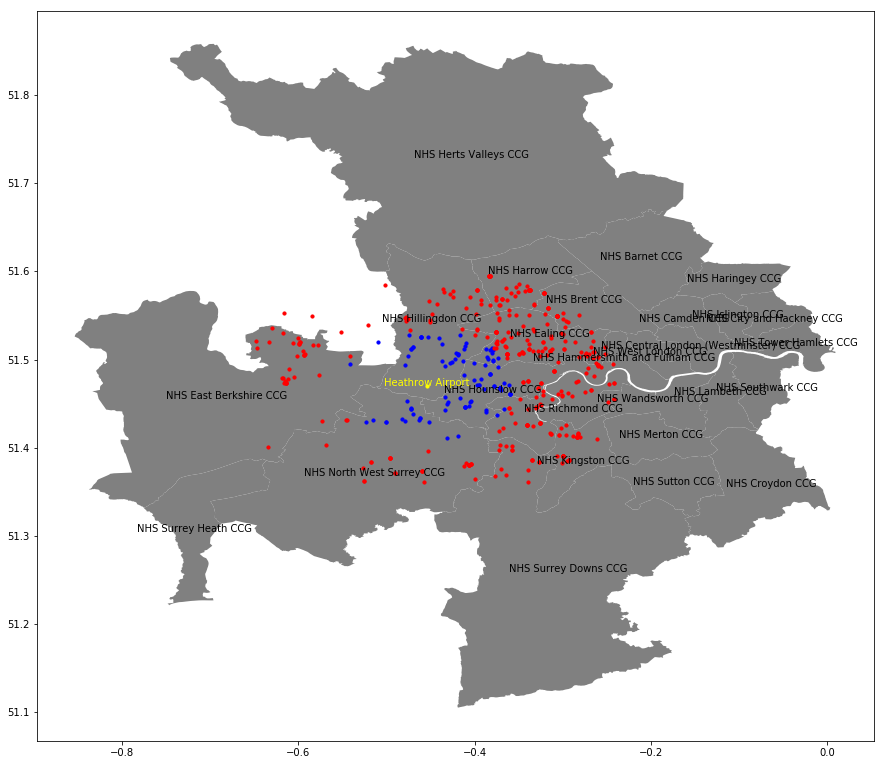

In [164]:
gp_geo_inner = gp_geo[gp_geo['heathrow_distance']<=7000]
gp_geo_outer = gp_geo[(gp_geo['heathrow_distance']>=7000) & (gp_geo['heathrow_distance']<15000)]


smaller_df = ldn_map_df_dist[ldn_map_df_dist['heathrow_distance'] <= 30000]

# solution inspired by stackoverflow. can also use (long,lat) as the midpoint
# https://stackoverflow.com/questions/38899190/geopandas-label-polygons
smaller_df['coords'] = smaller_df['geometry'].apply(lambda x: x.representative_point().coords[:])
smaller_df['coords'] = [coords[0] for coords in smaller_df['coords']]


fig, ax = plt.subplots(figsize=(15,15))
smaller_df.plot(ax=ax, color='grey',)
geo_df_airport.plot(ax=ax, markersize=10, color='yellow', marker='o')
gp_geo_inner.plot(ax=ax, markersize=10, color='blue', marker='o')
gp_geo_outer.plot(ax=ax, markersize=10, color='red', marker='o')

# plot the names on the midpoints
for idx, row in smaller_df.iterrows():
    plt.annotate(s=row['CCG19NM'], xy=row['coords'],
                 horizontalalignment='center')
    
# do the same for the airports (complete airport_df tomorrow)    
for idx, row in geo_df_airport.iterrows():
    plt.annotate(s=row['LOC_NAME'], xy=((row['LONG'], row['LAT'])),
                 horizontalalignment='center', color='yellow')
    
    
    
#